In [1]:
from api import *
from collections import defaultdict
import os

# Query and Download


Download traffic flow data for stations that report for the full 3 year peroid only

In [ ]:
! python download_reports.py all

Download traffic for the days of focus for the sattelite data

In [2]:
# Birmingham
start_date, end_date = '15062021', '15062021'
max_lat, max_long  = 52.50, -1.67
min_lat, min_long = 52.42, -1.75
clean_birmingham_report_df, birmingham_report_df = download_clean_pipeline(start_date, end_date, max_lat, max_long, min_lat, min_long, 40)
# Manchester
start_date, end_date = '19042019', '19042019'
max_lat, max_long  = 53.51,  -2.31
min_lat, min_long = 53.44,  -2.39
clean_manc_report_df,manc_report_df = download_clean_pipeline(start_date, end_date, max_lat, max_long, min_lat, min_long, 40)

# Cambridge
start_date, end_date = '02112021', '02112021'
max_lat, max_long  = 52.25,   0.11
min_lat, min_long = 52.19,   0.02
clean_cam_report_df, cam_report_df = download_clean_pipeline(start_date, end_date, max_lat, max_long, min_lat, min_long, 40)

# Thorpe
start_date, end_date = '08032022', '08032022'
max_lat, max_long  = 51.43,  -0.50
min_lat, min_long = 51.38,  -0.57
clean_thorpe_report_df, thorpe_report_df = download_clean_pipeline(start_date, end_date, max_lat, max_long, min_lat, min_long, 40)


# Epping
start_date, end_date = '08032022', '08032022'
max_lat, max_long  = 51.72,   0.15
min_lat, min_long = 51.62,   0.09
clean_epping_report_df, epping_report_df = download_clean_pipeline(start_date, end_date, max_lat, max_long, min_lat, min_long, 40)

# Bristol
start_date, end_date = '08082020', '08082020'
max_lat, max_long  = 51.60, -2.52
min_lat, min_long = 51.52, -2.59
clean_bristol_df, bristol_report_df = download_clean_pipeline(start_date, end_date, max_lat, max_long, min_lat, min_long, 40)

100%|██████████| 87/87 [00:07<00:00, 11.24it/s]


In [17]:
# Export these reports
clean_birmingham_report_df.reset_index(drop=True).to_feather('sattelite_time_traffic_reports/clean_birmingham_report_df')
clean_manc_report_df.reset_index(drop=True).to_feather('sattelite_time_traffic_reports/clean_manc_report_df')
clean_cam_report_df.reset_index(drop=True).to_feather('sattelite_time_traffic_reports/clean_cam_report_df')
clean_thorpe_report_df.reset_index(drop=True).to_feather('sattelite_time_traffic_reports/clean_thorpe_report_df')
clean_epping_report_df.reset_index(drop=True).to_feather('sattelite_time_traffic_reports/clean_epping_report_df')
clean_bristol_df.reset_index(drop=True).to_feather('sattelite_time_traffic_reports/clean_bristol_df')

In [2]:
# Import these reports
clean_birmingham_report_df = pd.read_feather('sattelite_time_traffic_reports/clean_birmingham_report_df')
clean_manc_report_df = pd.read_feather('sattelite_time_traffic_reports/clean_manc_report_df')
clean_cam_report_df = pd.read_feather('sattelite_time_traffic_reports/clean_cam_report_df')
clean_thorpe_report_df = pd.read_feather('sattelite_time_traffic_reports/clean_thorpe_report_df')
clean_epping_report_df = pd.read_feather('sattelite_time_traffic_reports/clean_epping_report_df')
clean_bristol_df = pd.read_feather('sattelite_time_traffic_reports/clean_bristol_df')

### TEMP QUERY DATA AVALIABILITY

In [4]:
time = datetime.datetime(2019,4,19,11,44)

In [52]:
clean_manc_report_df[(clean_manc_report_df.timestamp==time) & (clean_manc_report_df.site_id=='17580')]

,site_name,site_id,report_date,time_period_ending,time_interval,0-520cm,521-660cm,661-1160cm,1160+cm,avg_mph,total_volume,timestamp,0-520cm_normalised,521-660cm_normalised,661-1160cm_normalised,1160+cm_normalised,total_volume_normalised
3886,M60/9144A,17580,2019-04-19T00:00:00,11:44:00,46,1153,126,31,27,57,1337,2019-04-19 11:44:00,2.517811,2.959628,2.308766,1.476082,2.512027


In [50]:
clean_manc_report_df[(clean_manc_report_df.timestamp==time) & (clean_manc_report_df.site_id=='17555')]

,site_name,site_id,report_date,time_period_ending,time_interval,0-520cm,521-660cm,661-1160cm,1160+cm,avg_mph,total_volume,timestamp,0-520cm_normalised,521-660cm_normalised,661-1160cm_normalised,1160+cm_normalised,total_volume_normalised
3310,M60/9144B,17555,2019-04-19T00:00:00,11:44:00,46,813,34,23,27,59,897,2019-04-19 11:44:00,1.851321,1.393681,2.192651,1.384615,1.817552


## Get predictions of the traffic count

In [3]:
import copy

In [4]:
road_lengths = pd.read_csv('road_lengths.csv') 
traffic_data = copy.copy(road_lengths)

In [5]:
clean_train_report_df = pd.concat([clean_birmingham_report_df, clean_manc_report_df, clean_cam_report_df, clean_thorpe_report_df, clean_epping_report_df, clean_bristol_df])


sites = []
for x in list(traffic_data.sites):
    sites = sites + x.split(', ')
    
filtered_train_report = clean_train_report_df[['site_name','site_id','report_date','time_period_ending','time_interval','0-520cm','521-660cm','661-1160cm','1160+cm','avg_mph','total_volume','timestamp']][clean_train_report_df.site_id.isin(sites)]

In [6]:
# For a particular row x in road_lengths get the correspoiding traffic data
def area_report(x):
    sites = x.sites.split(', ')
    day, month, year = x.ddmmyy.split('/')
    hour, minute  = x.time.split(':')
    
    # Get the nearest of the 15 minute intervals to compare to
    min_mod_15 = round((int(minute)+1)/15)
    nearest_minute_interval = 15*min_mod_15 - 1
    time = datetime.datetime(int(year),int(month),int(day), int(hour), int(nearest_minute_interval))
    x_report = filtered_train_report[(filtered_train_report.site_id.isin(sites)) & (filtered_train_report.timestamp == time)]
    return x_report

# Add the reports to the dataframe
traffic_data['report'] = traffic_data.apply(area_report, axis=1)
# Extract values from the report
traffic_data['0-520cm'] = traffic_data.apply(lambda x: x.report['0-520cm'].sum(), axis=1)
traffic_data['521-660cm'] = traffic_data.apply(lambda x: x.report['521-660cm'].sum(), axis=1)
traffic_data['661-1160cm'] = traffic_data.apply(lambda x: x.report['661-1160cm'].sum(), axis=1)
traffic_data['1160+cm'] = traffic_data.apply(lambda x: x.report['1160+cm'].sum(), axis=1)
traffic_data['total_volume'] = traffic_data.apply(lambda x: x.report['total_volume'].sum(), axis=1)
traffic_data['avg_mph'] = traffic_data.apply(lambda x: x.report.avg_mph.astype(int).mean(), axis=1)

In [7]:
def predict_traffic_from_detector(traffic_data, threshold):
    # Initially set the column names so they agree with the names in the pickle files
    detections = pd.DataFrame(
       {
           "filename": [],
           "small_car_detections": [],
           "bus_detections": [],
           "pickup_truck_detections": [],
           "utility_truck_detections": [],
           "truck_detections": [],
           "cargo_truck_detections": [],
           "truck_w_box_detections": [],
           "truck_tractor_detections": [],
           "trailer_detections": [],
           "truck_w_flatbed_detections": [],
           "truck_w_liquid_detections": [],
           "all_vehicle_detections": [],

       }
    )

    # Import the predictions the pickle files
    pickle_folder = '/rds/general/user/jrb21/home/small-object-detection-benchmark/runs/highways/XVIEW_SAHI_PO19/pickles'
    prediction_lists = defaultdict()

    for i, file in enumerate(os.listdir(pickle_folder)):
        with (open(os.path.join(pickle_folder, file), "rb")) as f:
            prediction_list = pickle.load(f)
        filename = file.split('.')[0]
        prediction_lists[filename] = prediction_list
        counts = defaultdict(int)
        for pred in prediction_list:
            if pred.score.value > threshold:
                counts[pred.category.name] +=1

        detections.loc[i] = [filename, 
                     counts["Small Car"],
                     counts["Bus"],
                     counts["Pickup Truck"],
                     counts["Utility Truck"],
                     counts["Truck"],
                     counts["Cargo Truck"],
                     counts["Truck w/Box"],
                     counts["Truck Tractor"],
                     counts["Trailer"],
                     counts["Truck w/Flatbed"],
                     counts["Truck w/Liquid"],
                     sum([x for x in counts.values()])]
        
    # combine the reports    
    def detection_report(x):
        detections_report = detections[detections.filename == x.filename]
        return detections_report
    
    traffic_data['det_report'] = traffic_data.apply(detection_report, axis=1)
    
    # get the detection numbers
    traffic_data['small_car_detections'] = traffic_data.apply(lambda x: x.det_report.small_car_detections.sum(), axis=1)
    traffic_data['bus_detections'] = traffic_data.apply(lambda x: x.det_report.bus_detections.sum(), axis=1)
    traffic_data['pickup_truck_detections'] = traffic_data.apply(lambda x: x.det_report.pickup_truck_detections.sum(), axis=1)
    traffic_data['utility_truck_detections'] = traffic_data.apply(lambda x: x.det_report.utility_truck_detections.sum(), axis=1)
    traffic_data['truck_detections'] = traffic_data.apply(lambda x: x.det_report.truck_detections.sum(), axis=1)
    traffic_data['cargo_truck_detections'] = traffic_data.apply(lambda x: x.det_report.cargo_truck_detections.sum(), axis=1)
    traffic_data['truck_w_box_detections'] = traffic_data.apply(lambda x: x.det_report.truck_w_box_detections.sum(), axis=1)
    traffic_data['truck_tractor_detections'] = traffic_data.apply(lambda x: x.det_report.truck_tractor_detections.sum(), axis=1)
    traffic_data['trailer_detections'] = traffic_data.apply(lambda x: x.det_report.trailer_detections.sum(), axis=1)
    traffic_data['truck_w_flatbed_detections'] = traffic_data.apply(lambda x: x.det_report.truck_w_flatbed_detections.sum(), axis=1)
    traffic_data['truck_w_liquid_detections'] = traffic_data.apply(lambda x: x.det_report.truck_w_liquid_detections.sum(), axis=1)
    traffic_data['all_vehicle_detections'] = traffic_data.apply(lambda x: x.det_report.all_vehicle_detections.sum(), axis=1)

    # Predict the traffic count from these detections via raodlength and avg speed
    traffic_data['length_milles'] = traffic_data.length.apply(lambda x: x/1000 *5/8)
    traffic_data['time_to_cross_hour'] = traffic_data.apply(lambda x : x.length_milles/x.avg_mph * 1/2 , axis=1)
    traffic_data['time_to_cross_min'] = traffic_data.apply(lambda x : x.time_to_cross_hour * 60 , axis=1)

    detection_cols = ['small_car_detections',
     'bus_detections',
     'pickup_truck_detections',
     'utility_truck_detections',
     'truck_detections',
     'cargo_truck_detections',
     'truck_w_box_detections',
     'truck_tractor_detections',
     'trailer_detections',
     'truck_w_flatbed_detections',
     'truck_w_liquid_detections',
     'all_vehicle_detections']

    for col in detection_cols:
        pred_col = col.replace('detections', 'pred')
        traffic_data[pred_col] = traffic_data[col] * 15 / traffic_data['time_to_cross_min']
        
    return traffic_data

In [8]:
predict_traffic_from_detector(traffic_data, 0.2)

,ddmmyy,time,area,focus,length,sites,filename,report,0-520cm,521-660cm,...,pickup_truck_pred,utility_truck_pred,truck_pred,cargo_truck_pred,truck_w_box_pred,truck_tractor_pred,trailer_pred,truck_w_flatbed_pred,truck_w_liquid_pred,all_vehicle_pred
0,15/06/2021,11:09,birmingham,A452,2542.41,"9092, 9093",A452_birmingham,site_name site_id report_date ti...,321,44,...,0.0,0.0,33.668842,0.000000,16.834421,0.0,0.000000,0.000000,0.0,488.198206
1,15/06/2021,11:09,birmingham,M6,5549.01,"18212, 19227",M6_birmingham,site_name site_id report_date ti...,366,66,...,0.0,0.0,113.029171,16.147024,96.882147,0.0,16.147024,0.000000,0.0,758.910148
2,15/06/2021,11:09,birmingham,M42,7347.07,"10560, 10337, 10398",M42_birmingham,site_name site_id report_date t...,916,321,...,0.0,0.0,97.998250,39.199300,137.197549,0.0,0.000000,0.000000,0.0,1378.508712
3,15/06/2021,11:09,birmingham,A45,4559.31,"9490, 9491",A45_birmingham,site_name site_id report_date ti...,395,28,...,0.0,0.0,104.226297,28.425354,18.950236,0.0,9.475118,0.000000,0.0,577.982195
4,08/03/2022,11:12,thorpe,M25,8613.81,"1910, 6134",M25_thorpe,site_name site_id report_date t...,1853,250,...,0.0,0.0,263.298122,11.702139,87.766041,0.0,0.000000,0.000000,0.0,2147.342465
5,08/03/2022,11:12,thorpe,M25_2,6190.41,"5107, 4648",M25_2_thorpe,site_name site_id report_date t...,1845,229,...,0.0,0.0,165.546385,7.883161,55.182128,0.0,7.883161,0.000000,0.0,1860.426046
6,08/03/2022,11:12,thorpe,M3,9400.57,"14547, 14484, 14496, 14463, 14433",M3_thorpe,site_name site_id report_date t...,438,136,...,0.0,0.0,90.547701,0.000000,4.765668,0.0,9.531337,0.000000,0.0,524.223531
7,08/03/2022,11:12,thorpe,M3_2,4360.48,"14437, 14470",M3_2_thorpe,site_name site_id report_date ti...,1091,222,...,0.0,0.0,42.197189,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1329.211463
8,02/11/2021,11:26,cambridge,M11,5005.66,"2166, 3092, 4178, 9676",M11_cambridge,site_name site_id report_date ti...,731,61,...,0.0,0.0,76.593296,8.510366,59.572564,0.0,0.000000,0.000000,0.0,629.767104
9,02/11/2021,11:26,cambridge,M11_2,3308.62,"3092, 4178",M11_2_cambridge,site_name site_id report_date ti...,574,56,...,0.0,0.0,92.123000,0.000000,30.707667,0.0,15.353833,0.000000,0.0,475.968833


### Import the object detectors results

In [ ]:
# Initially set the column names so they agree with the names in the pickle files
detections = pd.DataFrame(
   {
       "filename": [],
       "small_car_detections": [],
       "bus_detections": [],
       "pickup_truck_detections": [],
       "utility_truck_detections": [],
       "truck_detections": [],
       "cargo_truck_detections": [],
       "truck_w_box_detections": [],
       "truck_tractor_detections": [],
       "trailer_detections": [],
       "truck_w_flatbed_detections": [],
       "truck_w_liquid_detections": [],
       "all_vehicle_detections": [],
       
   }
)

# Import the predictions the pickle files
pickle_folder = '/rds/general/user/jrb21/home/small-object-detection-benchmark/runs/highways/XVIEW_SAHI_PO17/pickles'
prediction_lists = defaultdict()

for i, file in enumerate(os.listdir(pickle_folder)):
    with (open(os.path.join(pickle_folder, file), "rb")) as f:
        prediction_list = pickle.load(f)
    filename = file.split('.')[0]
    prediction_lists[filename] = prediction_list
    counts = defaultdict(int)
    for pred in prediction_list:
        # if pred.score.value > 0.2:
            # print('true')
        counts[pred.category.name] +=1
        
    detections.loc[i] = [filename, 
                 counts["Small Car"],
                 counts["Bus"],
                 counts["Pickup Truck"],
                 counts["Utility Truck"],
                 counts["Truck"],
                 counts["Cargo Truck"],
                 counts["Truck w/Box"],
                 counts["Truck Tractor"],
                 counts["Trailer"],
                 counts["Truck w/Flatbed"],
                 counts["Truck w/Liquid"],
                 sum([x for x in counts.values()])]

In [8]:
def detection_report(x):
    detections_report = detections[detections.filename == x.filename]
    return detections_report

In [9]:
traffic_data['det_report'] = traffic_data.apply(detection_report, axis=1)

In [10]:
traffic_data['small_car_detections'] = traffic_data.apply(lambda x: x.det_report.small_car_detections.sum(), axis=1)
traffic_data['bus_detections'] = traffic_data.apply(lambda x: x.det_report.bus_detections.sum(), axis=1)
traffic_data['pickup_truck_detections'] = traffic_data.apply(lambda x: x.det_report.pickup_truck_detections.sum(), axis=1)
traffic_data['utility_truck_detections'] = traffic_data.apply(lambda x: x.det_report.utility_truck_detections.sum(), axis=1)
traffic_data['truck_detections'] = traffic_data.apply(lambda x: x.det_report.truck_detections.sum(), axis=1)
traffic_data['cargo_truck_detections'] = traffic_data.apply(lambda x: x.det_report.cargo_truck_detections.sum(), axis=1)
traffic_data['truck_w_box_detections'] = traffic_data.apply(lambda x: x.det_report.truck_w_box_detections.sum(), axis=1)
traffic_data['truck_tractor_detections'] = traffic_data.apply(lambda x: x.det_report.truck_tractor_detections.sum(), axis=1)
traffic_data['trailer_detections'] = traffic_data.apply(lambda x: x.det_report.trailer_detections.sum(), axis=1)
traffic_data['truck_w_flatbed_detections'] = traffic_data.apply(lambda x: x.det_report.truck_w_flatbed_detections.sum(), axis=1)
traffic_data['truck_w_liquid_detections'] = traffic_data.apply(lambda x: x.det_report.truck_w_liquid_detections.sum(), axis=1)
traffic_data['all_vehicle_detections'] = traffic_data.apply(lambda x: x.det_report.all_vehicle_detections.sum(), axis=1)


### Calculate a predicted count fromthe detections

In [12]:
traffic_data['length_milles'] = traffic_data.length.apply(lambda x: x/1000 *5/8)
traffic_data['time_to_cross_hour'] = traffic_data.apply(lambda x : x.length_milles/x.avg_mph * 1/2 , axis=1)
traffic_data['time_to_cross_min'] = traffic_data.apply(lambda x : x.time_to_cross_hour * 60 , axis=1)

detection_cols = ['small_car_detections',
 'bus_detections',
 'pickup_truck_detections',
 'utility_truck_detections',
 'truck_detections',
 'cargo_truck_detections',
 'truck_w_box_detections',
 'truck_tractor_detections',
 'trailer_detections',
 'truck_w_flatbed_detections',
 'truck_w_liquid_detections',
 'all_vehicle_detections']

for col in detection_cols:
    pred_col = col.replace('detections', 'pred')
    traffic_data[pred_col] = traffic_data[col] * 15 / traffic_data['time_to_cross_min']
    
pd.set_option('display.max_columns', None)


traffic_data

,ddmmyy,time,area,focus,length,sites,filename,report,0-520cm,521-660cm,661-1160cm,1160+cm,total_volume,avg_mph,det_report,small_car_detections,bus_detections,pickup_truck_detections,utility_truck_detections,truck_detections,cargo_truck_detections,truck_w_box_detections,truck_tractor_detections,trailer_detections,truck_w_flatbed_detections,truck_w_liquid_detections,all_vehicle_detections,length_milles,time_to_cross_hour,time_to_cross_min,small_car_pred,bus_pred,pickup_truck_pred,utility_truck_pred,truck_pred,cargo_truck_pred,truck_w_box_pred,truck_tractor_pred,trailer_pred,truck_w_flatbed_pred,truck_w_liquid_pred,all_vehicle_pred
0,15/06/2021,11:09,birmingham,A452,2542.41,"9092, 9093",A452_birmingham,site_name site_id report_date ti...,321,44,46,22,433,53.500000,filename small_car_detections bus_...,25,1,0,0,2,0,1,0,0,0,0,29,1.589006,0.014851,0.891032,420.860522,16.834421,0.0,0.0,33.668842,0.000000,16.834421,0.0,0.000000,0.000000,0.0,488.198206
1,15/06/2021,11:09,birmingham,M6,5549.01,"18212, 19227",M6_birmingham,site_name site_id report_date ti...,366,66,44,113,589,56.000000,filename small_car_detections bus_de...,61,3,0,0,14,2,12,0,2,0,0,94,3.468131,0.030965,1.857927,492.484245,24.220537,0.0,0.0,113.029171,16.147024,96.882147,0.0,16.147024,0.000000,0.0,758.910148
2,15/06/2021,11:09,birmingham,M42,7347.07,"10560, 10337, 10398",M42_birmingham,site_name site_id report_date t...,916,321,247,337,1821,60.000000,filename small_car_detections bus_...,151,18,0,0,15,6,21,0,0,0,0,211,4.591919,0.038266,2.295959,986.515713,117.597900,0.0,0.0,97.998250,39.199300,137.197549,0.0,0.000000,0.000000,0.0,1378.508712
3,15/06/2021,11:09,birmingham,A45,4559.31,"9490, 9491",A45_birmingham,site_name site_id report_date ti...,395,28,66,35,524,54.000000,filename small_car_detections bus_d...,42,2,0,0,11,2,2,0,1,0,0,60,2.849569,0.026385,1.583094,397.954954,18.950236,0.0,0.0,104.226297,18.950236,18.950236,0.0,9.475118,0.000000,0.0,568.507077
4,08/03/2022,11:12,thorpe,M25,8613.81,"1910, 6134",M25_thorpe,site_name site_id report_date t...,1853,250,241,209,2553,63.000000,filename small_car_detections bus_dete...,274,31,0,0,45,2,15,0,0,0,0,367,5.383631,0.042727,2.563634,1603.193012,181.383151,0.0,0.0,263.298122,11.702139,87.766041,0.0,0.000000,0.000000,0.0,2147.342465
5,08/03/2022,11:12,thorpe,M25_2,6190.41,"5107, 4648",M25_2_thorpe,site_name site_id report_date t...,1845,229,209,223,2506,61.000000,filename small_car_detections bus_de...,199,6,0,0,21,1,7,0,1,0,0,235,3.869006,0.031713,1.902790,1568.749081,47.298967,0.0,0.0,165.546385,7.883161,55.182128,0.0,7.883161,0.000000,0.0,1852.542885
6,08/03/2022,11:12,thorpe,M3,9400.57,"14547, 14484, 14496, 14463, 14433",M3_thorpe,site_name site_id report_date t...,438,136,80,39,693,56.000000,filename small_car_detections bus_detect...,88,0,0,0,19,0,1,0,2,0,0,110,5.875356,0.052459,3.147512,419.378825,0.000000,0.0,0.0,90.547701,0.000000,4.765668,0.0,9.531337,0.000000,0.0,524.223531
7,08/03/2022,11:12,thorpe,M3_2,4360.48,"14437, 14470",M3_2_thorpe,site_name site_id report_date ti...,1091,222,132,159,1604,57.500000,filename small_car_detections bus_det...,122,0,0,0,4,0,0,0,0,0,0,126,2.725300,0.023698,1.421896,1287.014274,0.000000,0.0,0.0,42.197189,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1329.211463
8,02/11/2021,11:26,cambridge,M11,5005.66,"2166, 3092, 4178, 9676",M11_cambridge,site_name site_id report_date ti...,731,61,59,130,981,53.250000,filename small_car_detections bus_d...,47,10,0,0,9,1,7,0,0,0,0,74,3.128537,0.029376,1.762556,399.987214,85.103663,0.0,0.0,76.593296,8.510366,59.572564,0.0,0.000000,0.000000,0.0,629.767104
9,02/11/2021,11:26,cambridge,M11_2,3308.62,"3092, 4178",M11_2_cambridge,site_name site_id report_date ti...,574,56,50,127,807,63.500000,filename small_car_detections bus...,20,2,0,0,6,0,2,0,1,0,0,31,2.067887,0.016283,0.976955,307.076666,30.707667,0.0,0.0,92.123000,0.000000,30.707667,0.0,15.353833,0.000000,0.0,475.968833


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

### Plot predicted vs total

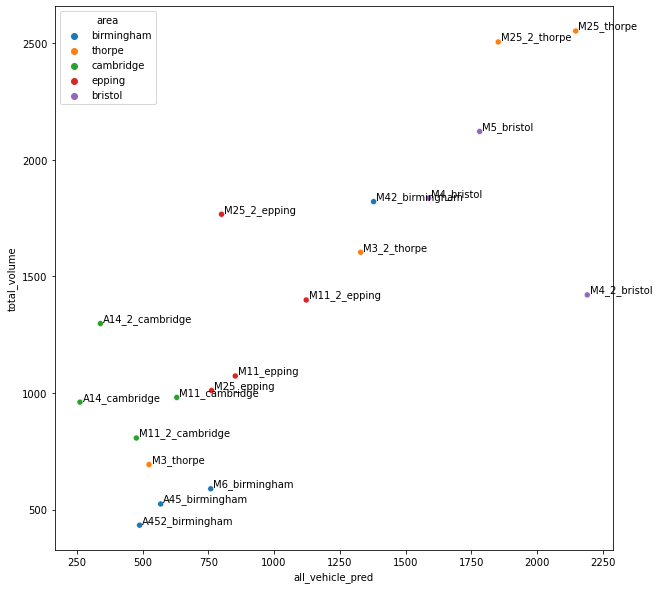

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='all_vehicle_pred', y='total_volume', hue='area', data=traffic_data, ax=ax)
for i in range(traffic_data.shape[0]):
     plt.text(traffic_data.all_vehicle_pred[i]+10, traffic_data.total_volume[i]+10, traffic_data.filename[i])

plt.show()

# Regional Download

In [3]:
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon

In [4]:
def get_region(x):
    for row in regions_gdf.iterrows():
        name = row[1].nuts118nm
        region = row[1].geometry
        x_name = 'other'
        if region.contains(Point(x.Longitude, x.Latitude)):
            x_name = name
            return x_name
    return x_name

In [5]:
# filter down sites onto our regions of focus
regions_gdf = geopandas.read_file("NUTS_Level_1_(January_2018)_Boundaries.geojson")

sites_df = pd.DataFrame(data = sites)
sites_df['region'] = sites_df.apply(get_region, axis=1)

In [6]:
focus_regions = ['South East (England)', 
                 'East of England', 
                 'West Midlands (England)', 
                 'North West (England)', 
                 'South West (England)']

focus_sites_df = sites_df[sites_df.region.isin(focus_regions)]
focus_sites_df = focus_sites_df.reset_index(drop=True)
focus_sites_df['road_type'] = focus_sites_df.Description.apply(lambda x : x.split('/')[0][0])
focus_sites_motorway_df = focus_sites_df[focus_sites_df.road_type == 'M']

In [ ]:
# Get quality filter these sites down to quality > 90%
start_date, end_date = '19032019', '08042022'
quality_sites = get_quality_area(focus_sites_motorway_df, start_date = start_date, end_date = end_date)

In [7]:
quality_sites = pd.read_feather('quality_sites_motorway')

In [8]:
SE_sites_df = quality_sites[quality_sites.region == 'South East (England)']
EE_sites_df = quality_sites[quality_sites.region == 'East of England']
WM_sites_df = quality_sites[quality_sites.region == 'West Midlands (England)']
NW_sites_df = quality_sites[quality_sites.region == 'North West (England)']
SW_sites_df = quality_sites[quality_sites.region == 'South West (England)']

In [ ]:
start_date, end_date = '19032019', '08042022'

SE_report_df = get_reports_from_sites_df(SE_sites_df, start_date, end_date)
SE_report_df.to_feather('SE_report_df')
del SE_report_df

EE_report_df = get_reports_from_sites_df(EE_sites_df, start_date, end_date)
EE_report_df.to_feather('EE_report_df')
del EE_report_df

WM_report_df = get_reports_from_sites_df(WM_sites_df, start_date, end_date)
WM_report_df.to_feather('WM_report_df')
del WM_report_df

NW_report_df = get_reports_from_sites_df(NW_sites_df, start_date, end_date)
NW_report_df.to_feather('NW_report_df')
del NW_report_df

SW_report_df = get_reports_from_sites_df(SW_sites_df, start_date, end_date)
SW_report_df.to_feather('SW_report_df')
del SW_report_df

 10%|█         | 51/489 [21:05<3:01:06, 24.81s/it]